# Recurrent Neural Networks (RNN)

## 1.	Introduction


### Text mining and NLP problems (IMDB reviews dataset)

-	This project will explore and analyze the information stored in a particular dataset. In this case the IMDB reviews dataset (https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews). We will explore different RNN models.

This project will deliver three different tasks:
1. Implement the selected model.
2. Tuning the presented models and describing how and why the results get improvement.
3. Compare the final model with one other RNN model. 
 

In [1]:
# Define all and only used package imports below
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

#!pip install opendatasets
import opendatasets as od #load kaggle datasets

# !pip install nltk
from nltk.corpus import stopwords # to calculate the number of stopwords
import nltk
nltk.download('stopwords')

# to create the wordcloud
# !pip install wordcloud 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from PIL import Image
import requests
from io import BytesIO

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alext\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
UsageError: Line magic function `%` not found.


## 2.	ELT

### Extract, Load and Transform of data.



- Data should be retrieved from an online source, NOT from your local drive, otherwise, nobody can run your code without additional effort.
- Check the following link on how to retrieve data from kaggle https://www.analyticsvidhya.com/blog/2021/04/how-to-download-kaggle-datasets-using-jupyter-notebook/

In [2]:
# Download data from kaggle
od.download("https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

# Read the downloaded file
data = pd.read_csv('.\imdb-dataset-of-50k-movie-reviews\IMDB Dataset.csv')

Skipping, found downloaded files in ".\imdb-dataset-of-50k-movie-reviews" (use force=True to force download)


### Report the essential description of data.
-	Don’t print out dozens of raw lines.

In [3]:
# Number of words
data['word_count'] = data['review'].apply(lambda x: len(str(x).split(" ")))
data[['review','word_count']]

#Number of characters
data['char_count'] = data['review'].str.len() ## this also includes spaces
data[['review','char_count']]

# Average word length
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

data['avg_word'] = data['review'].apply(lambda x: avg_word(x))

# Number of stop words 
stop = stopwords.words('english')
data['stopwords'] = data['review'].apply(lambda x: len([x for x in x.split() if x in stop]))

# Number of Uppercase words
data['upper'] = data['review'].apply(lambda x: len([x for x in x.split() if x.isupper()]))

# Descriptive statistics of the DataFrame
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
word_count,50000.0,231.145940,171.326419,4.000000,126.000000,173.000000,280.000000,2470.000000
char_count,50000.0,1309.431020,989.728014,32.000000,699.000000,970.000000,1590.250000,13704.000000
avg_word,50000.0,4.640676,0.340731,1.239865,4.417904,4.627006,4.847458,12.290909
stopwords,50000.0,94.768780,71.682687,0.000000,51.000000,72.000000,115.000000,1004.000000
upper,50000.0,4.857800,5.627519,0.000000,1.000000,3.000000,6.000000,162.000000


## 3.	Modeling

### Prepare analytics here and construct all the data objects you will use in your report.
•	Write functions and classes to simplify tasks. Do not repeat yourself.

•	Avoid output.

•	Refactor your code until it’s clean

In [4]:
text = " ".join(review for review in data.review.astype(str))
print ("There are {} words in the combination of all cells in column review.".format(len(text)))
stopwords = set(STOPWORDS)

# to exclude certain words
stopwords.update(["br", "one", "want", "come", "gets","without", 'rather', "although", "will", "see", "even","make", "seem"])


There are 65521550 words in the combination of all cells in column review.


## 4.	Results

•	Print out relevant tables nicely, display well-annotated charts and explain if needed in plain English.
•	Use minimum code here, just output-functions’ calls.

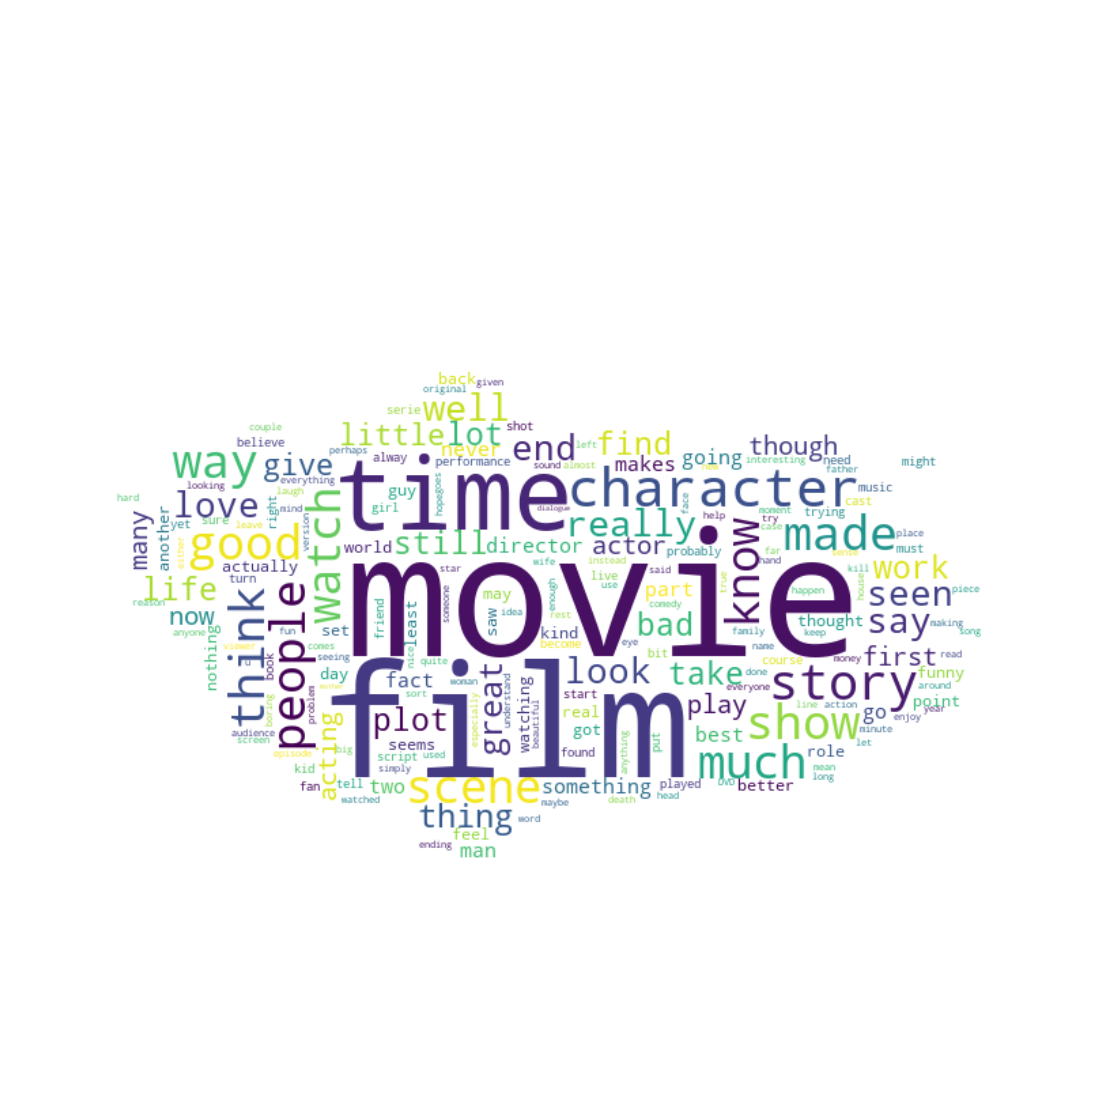

In [9]:
# Generate a word cloud image
url = "https://thumbs.dreamstime.com/b/black-cloud-smoke-isolated-over-white-background-shape-illustration-102945454.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

mask = np.array(img)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=400, height=200, mask=mask).generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(40,20))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 5.	Conclusions

•	Summarize your findings here in 5...10 lines of text.

In [ ]:
#! git clone https://github.com/AlexTouvras/FindingSimilarItems

In [ ]:
#! git add -A

In [8]:
! git commit -am "dataset and initial descriptive statistics" 
! git push 

[main 4cd716a] dataset and initial descriptive statistics
 2 files changed, 164 insertions(+), 144 deletions(-)


The file will have its original line endings in your working directory
The file will have its original line endings in your working directory
To https://github.com/AlexTouvras/RecurrentNeuralNetworks
   b343377..4cd716a  main -> main
